# Transforming workflow for coeanography study using S2 data, from SAFE to ZARR

This is a part of  notebook which we will show the example of transformation of research workflow using SAFE file format to new EOPF ZARR format. 


We use example from a repository https://github.com/cuevas-a97/S2_Codes , which shows the computation of oceanic current using S2L1C images. 

This notebook  show the workflow using zarr format.  

First, we  download the research software from the original git repository, and get access to new EOPF zarr format S2L1C data 

## download the research software 

## Access the Analysisi Ready Clowed Optimised EOPF ZARR  file
### Import dependencies accessing the  EOPF ZARR format. 

It is very easy. I used EOPF Sample service example notebook and just copied pasted some cells. 
https://eopf-sample-service.github.io/eopf-sample-notebooks/stac-eopf-zarr-sentinel


In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
from pystac_client import CollectionSearch
from matplotlib.gridspec import GridSpec

In [31]:
items = list(
    catalog.search(
        collections=["sentinel-2-l1c"],
        bbox=[7.2, 44.5, 7.4, 44.7],
        datetime=["2025-01-30", "2025-05-01"],
        query={
            "eo:cloud_cover": {"lt": 10},
        },
    ).items()
)
items

[<Item id=S2C_MSIL1C_20250425T102041_N0511_R065_T32TLQ_20250425T143559>,
 <Item id=S2A_MSIL1C_20250410T102701_N0511_R108_T32TLQ_20250410T172716>,
 <Item id=S2B_MSIL1C_20250410T101559_N0511_R065_T32TLQ_20250410T124518>]

In [40]:
#lets try to specify 'ocean' point and see if we have any specific metadta to collect 'ocean' parts from stac catalog,

catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
LON, LAT = 111, -26
LON, LAT = -5, 48

date = "2025-07-07/2025-07-11"
collections=['sentinel-2-l1c']
# Search with cloud cover filter
items = list(
    catalog.search(
#        datetime=date,
        collections=collections,
    intersects=dict(type="Point", coordinates=[LON, LAT]),
        query={
            "eo:cloud_cover": {"lt": 1},
        },
    ).items()
)
print(items)
# Inspect metadata of first item
if items:
    item = items[0]
    print(f"Item ID: {item.id}\n")

    # Print properties clearly
    print("Metadata properties:\n")
    for key, value in item.properties.items():
        print(f"- {key}: {value}")
else:
    print("No items found!")

[<Item id=S2A_MSIL1C_20250624T112131_N0511_R037_T30UUU_20250624T135219>, <Item id=S2A_MSIL1C_20250624T112131_N0511_R037_T29UQP_20250624T135219>, <Item id=S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418>, <Item id=S2A_MSIL1C_20250515T112131_N0511_R037_T30UUU_20250515T135720>, <Item id=S2A_MSIL1C_20250515T112131_N0511_R037_T29UQP_20250515T135720>]
Item ID: S2A_MSIL1C_20250624T112131_N0511_R037_T30UUU_20250624T135219

Metadata properties:

- gsd: 10.0
- created: 2025-06-24T13:52:19Z
- mission: copernicus
- sci:doi: 10.5270/S2_-742ikth
- updated: 2025-06-24T13:52:19Z
- datetime: 2025-06-24T11:21:31.024000Z
- platform: sentinel-2a
- grid:code: MGRS-30UUU
- proj:bbox: [-5.719358495228302, 47.734155602346505, -4.203598297764804, 48.74648044472784]
- proj:code: EPSG:32630
- providers: [{'url': 'https://commission.europa.eu/', 'name': 'European Commission', 'roles': ['licensor']}, {'url': 'https://sentinel.esa.int/web/sentinel/missions/copernicus', 'name': 'ESA', 'roles': ['produce

In [42]:
item = items[0]  # extracting the first item

ds = xr.open_dataset(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)  # The engine="eopf-zarr" is already embedded in the STAC metadata

#ds.quality_l2a_quicklook_r60m_tci.plot.imshow(rgb="quality_l2a_quicklook_r60m_band")

ds

ValueError: unrecognized engine 'eopf-zarr' must be one of your download engines: ['netcdf4', 'h5netcdf', 'scipy', 'argo', 'cfgrib', 'gini', 'kerchunk', 'pydap', 'rasterio', 'store', 'zarr']. To install additional dependencies, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

# we can define 'sun azimuth and sun_elevation, can't this be something helpful for the app?
## to do add eopf reader stuff?
## find image existing in the l1c that has 0 coverage cloud but on ocean.

In [10]:
!ls

LICENSE
README.md
S2B_MSIL1C_20240401T024319_N0510_R003_T49JDM_20240401T054723.SAFE
S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE
S2_Codes
bande4.png
environment.yml
img1_filtered.png
tina.ipynb


## Start processing data
### prepare enviroment and load input safe format data

In [13]:
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
import sys
import os
from scipy.interpolate import interpolate
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.io import savemat
from scipy.io import loadmat
from skimage.filters import sobel

# PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'

#os.chdir('/home/acuevas/Bureau/S2_ALEXANDRA/OPTOOLS/PYTHON/Carte_courant')
import sys
sys.path.append("S2_Codes/fonction")


from spectral_analysis_functions import FFT2D_two_arrays_nonan
# Using OceanDataLab reader 
#from sentinel2_l1c import *
import numpy as np
from S2_read import S2_read, find
from s2_angs import tan

import warnings
warnings.simplefilter('default')

bands=['B04','B08','B03','B02'];  

#Masha 2016
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PWL_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PWM_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PWN_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PXL_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PXM_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PXN_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PYL_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PYM_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PYN_20160827T065722.SAFE/'

#Californie 2023
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SBF_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SCF_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SCG_20230427T223909.SAFE/'

# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SDF_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SDG_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SBH_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/30_04_2023/S2B_MSIL1C_20230430T190919_N0509_R056_T10SBG_20230430T211611.SAFE'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SDG_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SDH_20230427T223909.SAFE/'

 #Australie
S2path='/home/acuevas/Bureau/S2_ALEXANDRA/Australie/S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/Australie/S2B_MSIL1C_20240401T024319_N0510_R003_T49JEN_20240401T054723.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/Australie/S2B_MSIL1C_20240401T024319_N0510_R003_T49JFM_20240401T054723.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/Australie/S2B_MSIL1C_20240401T024319_N0510_R003_T49JFN_20240401T054723.SAFE/'
S2path='./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/'
#S2path=safe_filename+'/'
Sat='A' # should change depending on the satellite S2A or S2b


### Image reading 
Verify the enviomrnet has the right tool installed

In [2]:
#!pip install pylibjpeg-openjpeg
#XML_File = find('MTD_TL.xml', S2path)
#XML_File
import rasterio
with rasterio.Env() as env:
    drivers = env.drivers()
    print("JP2OpenJPEG" in drivers)
    print("JP2OpenJPEG mode:", drivers.get("JP2OpenJPEG"))

True
JP2OpenJPEG mode: JPEG-2000 driver based on JP2OpenJPEG library


In [3]:
XML_File = find('MTD_TL.xml', S2path)
XML_File_DS=find('MTD_DS.xml',S2path)
if XML_File is None:
    print("Le fichier 'MTD_TL.xml' n'a pas été trouvé dans le répertoire spécifié:", S2path)


boxi1=[2500,3000,3000,3500] # East West South North : this box is covered by another detector
[imgs1,NX1,NY1,nx1,ny1,dx1,dy1,offspec1,phitrig1,thetav1,loncenter1,latcenter1,detector,indexX,indexY]=S2_read(S2path,boxi1,bands)
boxi=[8000,8500,5000,5500]
[imgs,NX,NY,nx,ny,dx,dy,offspec,phitrig,thetav,loncenter,latcenter,detector,indexX,indexY]=S2_read(S2path,boxi,bands)

# print('Nx',NX)
# print('Ny',NY)
# print('nx',nx)
# print('ny',ny)
# print('dx',dx)
# print('dy',dy)
print(np.degrees(loncenter))
print(np.degrees(latcenter))

test: ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/
Reading XML file for view and sun angles: ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/MTD_TL.xml
Reading file for band  B04 : ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA/T49JEM_20240401T024319_B04.jp2
Reading file for band  B08 : ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA/T49JEM_20240401T024319_B08.jp2
Reading file for band  B03 : ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA/T49JEM_20240401T024319_B03.jp2
Reading file for band  B02 : ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA/T49JEM_20240401T024319_B02.jp2
x and y indices in angles arrays: 6 15
ba

!ls S2_Codes/

### Use S2_codes/Visualisation to visualise the image

./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA


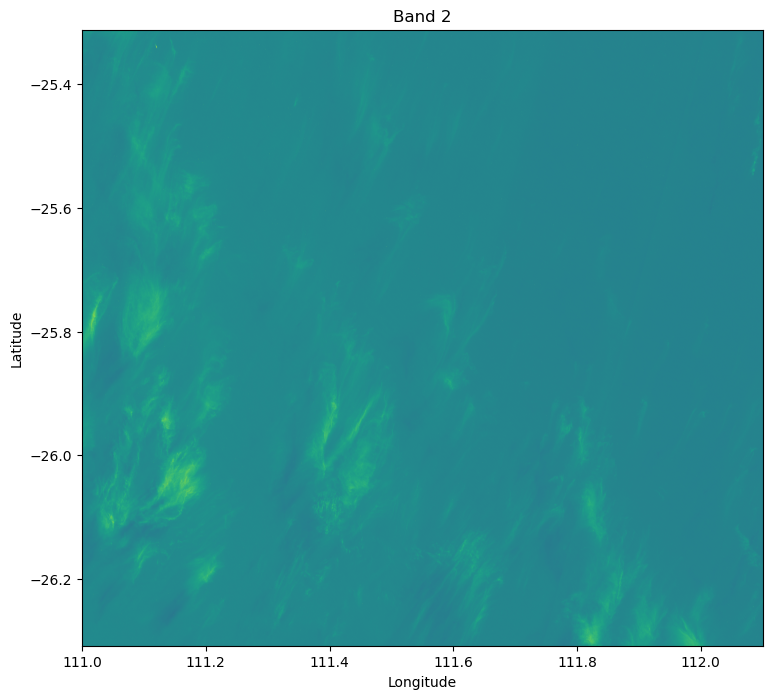

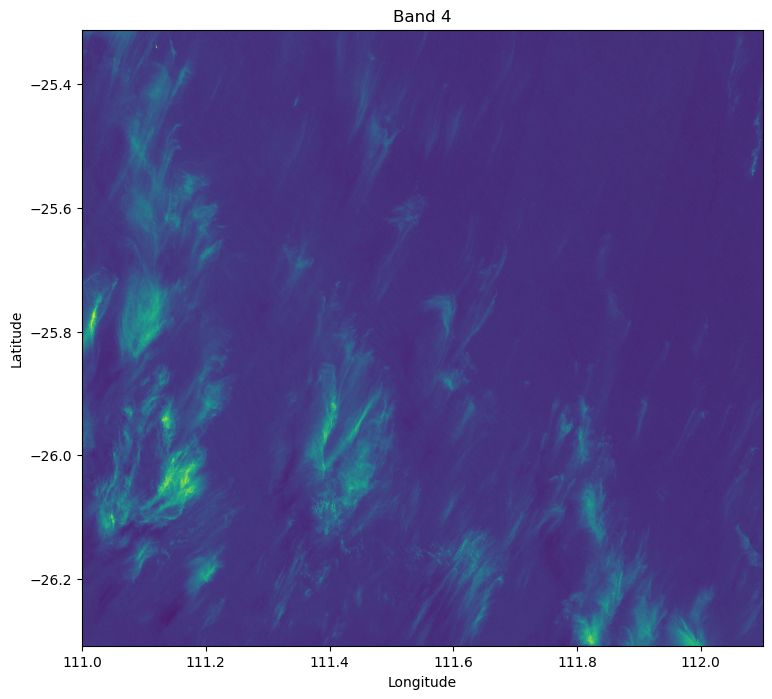

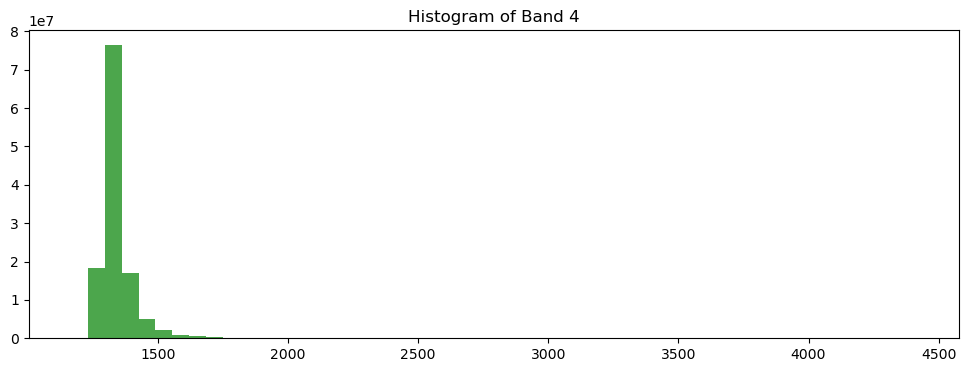

[110.99979963035028, 112.09974791439986, -26.307696430569262, -25.31215761744814]


/tmp/ipykernel_7208/292770347.py:40: UserWarning: Adding colorbar to a different Figure <Figure size 1200x400 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(im)


<Figure size 640x480 with 0 Axes>

minlon 110.99979963035028
minlat -26.307696430569262
maxlon 112.09974791439986
maxlat -25.31215761744814


In [29]:
%run S2_Codes/Visualisation_image.ipynb

### Image based on detectors

lon,lat: 112.71096832734311 64.40036585069615
means: [1314.  1187.5 1518.  1915.5]
Median brighness in B04 and mss: 1320.0 1308.0 0.6572957404348737 0.990909090909091 1.0431278391291323 20.680323619922547 22.060943594188878


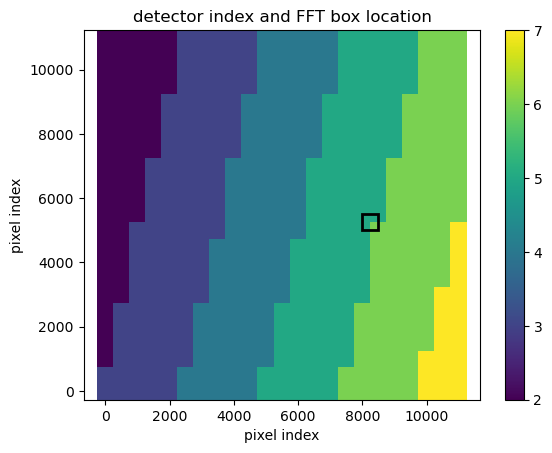

G4 0.32864684103968345
[8000, 8500, 5000, 5500]


In [4]:
print('lon,lat:',np.degrees(loncenter),np.degrees(latcenter))

nb=np.shape(bands)[0]
# Mother_box=[4800,10000,7200,10300]
Mother_box=[2000, 10000, 6000,10000]

taille_boite=500
# taille_boite=700

width=(Mother_box[1] - Mother_box[0]) // taille_boite 
length=(Mother_box[3] - Mother_box[2]) // taille_boite 

# boxi=[6000, 6500, 8000, 8500]
# boxi=[7600,8100,4500,5000]
B04med1=np.median(imgs1[0,:,:].flatten())
B04med=np.median(imgs[0,:,:].flatten())
B08med1=np.median(imgs1[1,:,:].flatten())
B08med=np.median(imgs[1,:,:].flatten())

mediansb=0.5*(np.median(imgs,axis=(1, 2))+np.median(imgs1,axis=(1, 2)))
print('means:',mediansb)

ratio=B04med/B04med1
G4=(B04med-B04med1)/(tan(np.radians(offspec[0]))-tan(np.radians(offspec1[0])))/mediansb[0]
G8=(B08med-B08med1)/(tan(np.radians(offspec[1]))-tan(np.radians(offspec1[1])))/mediansb[1]
                         
Bd1=(np.cos(np.radians(offspec1[0])))**4*np.cos(np.radians(thetav1[0]))
Bd=(np.cos(np.radians(offspec[0])))**4*np.cos(np.radians(thetav[0]))
mss=(np.tan(np.radians(offspec1[0]))**2-np.tan(np.radians(offspec[0]))**2)/np.log(ratio*Bd/Bd1)

print('Median brighness in B04 and mss:',B04med1,B04med,mss,ratio,Bd/Bd1,offspec[0],offspec1[0])
array1=np.squeeze(detector[1,:,:])
fig, ax = plt.subplots() 
im=ax.pcolor(indexX,indexY,array1)
fig.colorbar(im)
ax.set_title('detector index and FFT box location')
ax.set_xlabel('pixel index')
ax.set_ylabel('pixel index')
ax.axis('equal')
rect = mp.patches.Rectangle((boxi[0], boxi[2]), boxi[1]-boxi[0], boxi[3]-boxi[2], linewidth=2,
                         edgecolor='k', facecolor="none")


ax.add_patch(rect)
plt.show()
print('G4',G4)
print(boxi)

### Identifying the detector

In [5]:
# On determine le centre de la boîte en pixel
def centre_carre(x0,xy0,taille_boite):
    centrex=x0+taille_boite/2
    centrey=y0+taille_boite/2
    return centrex, centrey

x0=boxi[0]
y0=boxi[2]
taille_boite=boxi[1]-boxi[0]
centre=centre_carre(x0,y0,taille_boite)

print('centre boxi',centre)

centre boxi (8250.0, 5250.0)


In [6]:
indexX2, indexY2 = np.meshgrid(indexX, indexY)
print('shape indexX',np.shape(indexX))
print('shape indexY',np.shape(indexY))
print('shape array1',np.shape(array1))


points = np.column_stack((indexX.ravel(), indexY.ravel()))
values = array1.ravel()

# Interpolation
value = griddata(points, values, centre, method='linear')
value = value.item() 
detector_find=round(value)
print(detector_find)

shape indexX (23, 23)
shape indexY (23, 23)
shape array1 (23, 23)
5


### Dictionary of detector numbers

In [7]:
mapping = {
    1: 'D01',
    2: 'D02',
    3: 'D03',
    4: 'D04',
    5: 'D05',
    6: 'D06',
    7: 'D07',
    8: 'D08',
    9: 'D09',
    10: 'D10',
    11: 'D11',
    12: 'D12'
}
if round(value) in mapping:
    Det = mapping[round(value)]
else:
    Det = "Valeur non trouvée"
print(Det)

D05


In [8]:
import math

#loncenter2=loncenter*180/(math.pi)
#latcenter2=(latcenter*180/math.pi)
loncenter2 = math.degrees(loncenter)
latcenter2 = math.degrees(latcenter)

print(Det)
print(loncenter2)
print(latcenter2)


D05
112.71096832734311
64.40036585069615


### Image normalisation and filtering

#### Normalisation
We look at the band B04 and B02 -->  bands=['B04','B08','B03','B02']; 

1308.0
[[1319 1304 1312 ... 1278 1281 1294]
 [1307 1310 1333 ... 1271 1279 1287]
 [1334 1307 1309 ... 1260 1278 1298]
 ...
 [1320 1322 1311 ... 1326 1328 1301]
 [1324 1319 1310 ... 1370 1362 1327]
 [1309 1295 1283 ... 1386 1345 1344]]


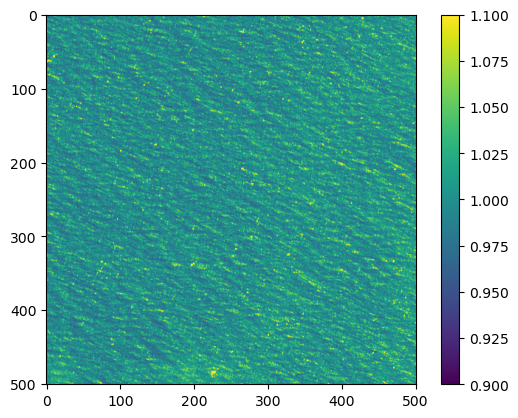

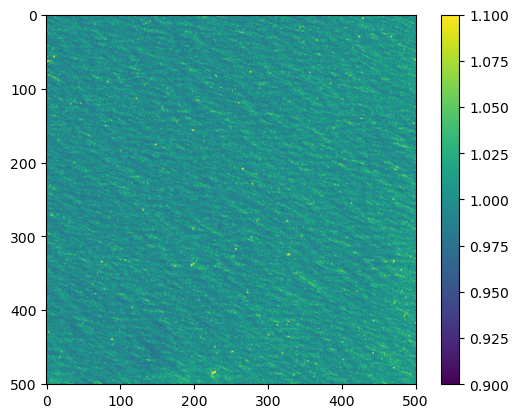

In [9]:
# normalizes the image values
print(np.median(imgs[0,:,:].flatten()))
print(imgs[0,:,:])
img1=imgs[0,:,:]/np.median(imgs[0,:,:].flatten())
img2=imgs[3,:,:]/np.median(imgs[3,:,:].flatten())
plt.imshow(np.flipud(np.transpose(img1)),vmin=0.9, vmax=1.1) #edit your vmin, vmax and cmap if you don't like greyscale colormap
plt.colorbar()

plt.show()
plt.imshow(np.flipud(np.transpose(img2)),vmin=0.9, vmax=1.1) #edit your vmin, vmax and cmap if you don't like greyscale colormap
plt.colorbar()
plt.show()
# Sauvegarder au format .mat
# savemat('imgs_frag1_7km.mat', {'data':imgs})

#### Filtering white cap (Sobel filter)

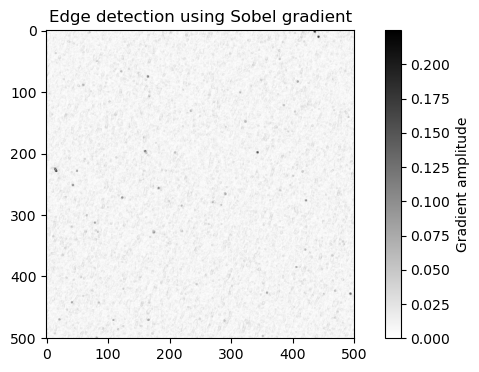

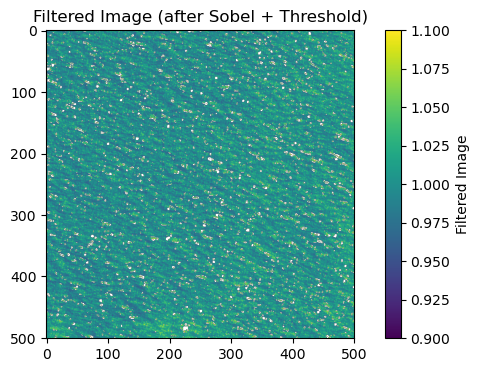

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter

# img_smooth = gaussian_filter(img1, sigma=1)
# gradient_sobel1 = sobel(img_smooth)
# img_smoot2 = gaussian_filter(img2, sigma=1)
# gradient_sobel2 = sobel(img_smoot2)


#Compute the Sobel gradient
gradient_sobel1 = sobel(img1)
gradient_sobel2 = sobel(img2)

# Visualize the gradient
plt.figure(figsize=(8, 4))
plt.imshow(gradient_sobel2, cmap="gist_gray_r", origin="upper")
plt.colorbar(label="Gradient amplitude")
plt.title("Edge detection using Sobel gradient")
plt.show()

# Define an automatic threshold using the 95th percentile
threshold = np.percentile(gradient_sobel1, 95)  
threshold2 = np.percentile(gradient_sobel2, 95)  

# Keep areas with a low gradient
mask = gradient_sobel1 < threshold  
mask2 = gradient_sobel2 < threshold2  

# Apply the mask to the original image
filtered_image1 = np.where(mask, img1, np.nan)  # Replace masked pixels with NaN
filtered_image2 = np.where(mask2, img2, np.nan)  # Replace masked pixels with NaN

# Display the filtered image
plt.figure(figsize=(8, 4))
plt.imshow(np.flipud(np.transpose(filtered_image1)), cmap="viridis", vmin=0.9, vmax=1.1, origin="upper")
plt.colorbar(label="Filtered Image")
plt.title("Filtered Image (after Sobel + Threshold)")
plt.savefig('img1_filtered.png')
plt.show()



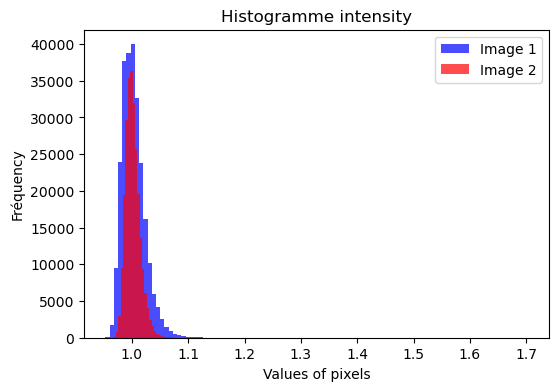

In [11]:
# Display the histogram of values for the original image
plt.figure(figsize=(6, 4))
plt.hist(img1.ravel(), bins=100, color='blue', alpha=0.7, label='Image 1')
plt.hist(img2.ravel(), bins=100, color='red', alpha=0.7, label='Image 2')
plt.xlabel("Values of pixels")
plt.ylabel("Fréquency")
plt.title("Histogramme intensity")
plt.legend()
plt.show()


### Fourier transform with two images

ntile: numbers of tile used for the welch. In the function FTT2D_two_arrays_nonan replaces the nan values in the images with the local mean. The function used when the image is not filtered is FFT2D _two_arrays

spectrum of the brightness of image\
coherence and phase between two images tzo bands \

this notebook show hz to get wave information from S2 L1C image. 


(31, 31)
(31, 31)
(31, 31)
variance 1: 0.0004334028690143548 sum of spectrum: 0.0003343315762079882
variance 2: 0.00017616621011375488 sum of spectrum: 0.00013200304724694608


/tmp/ipykernel_24438/3867747166.py:66: RuntimeWarning: invalid value encountered in log10
  im=axs[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10((crosr)),norm = mcolors.Normalize(vmin=-30, vmax=20))


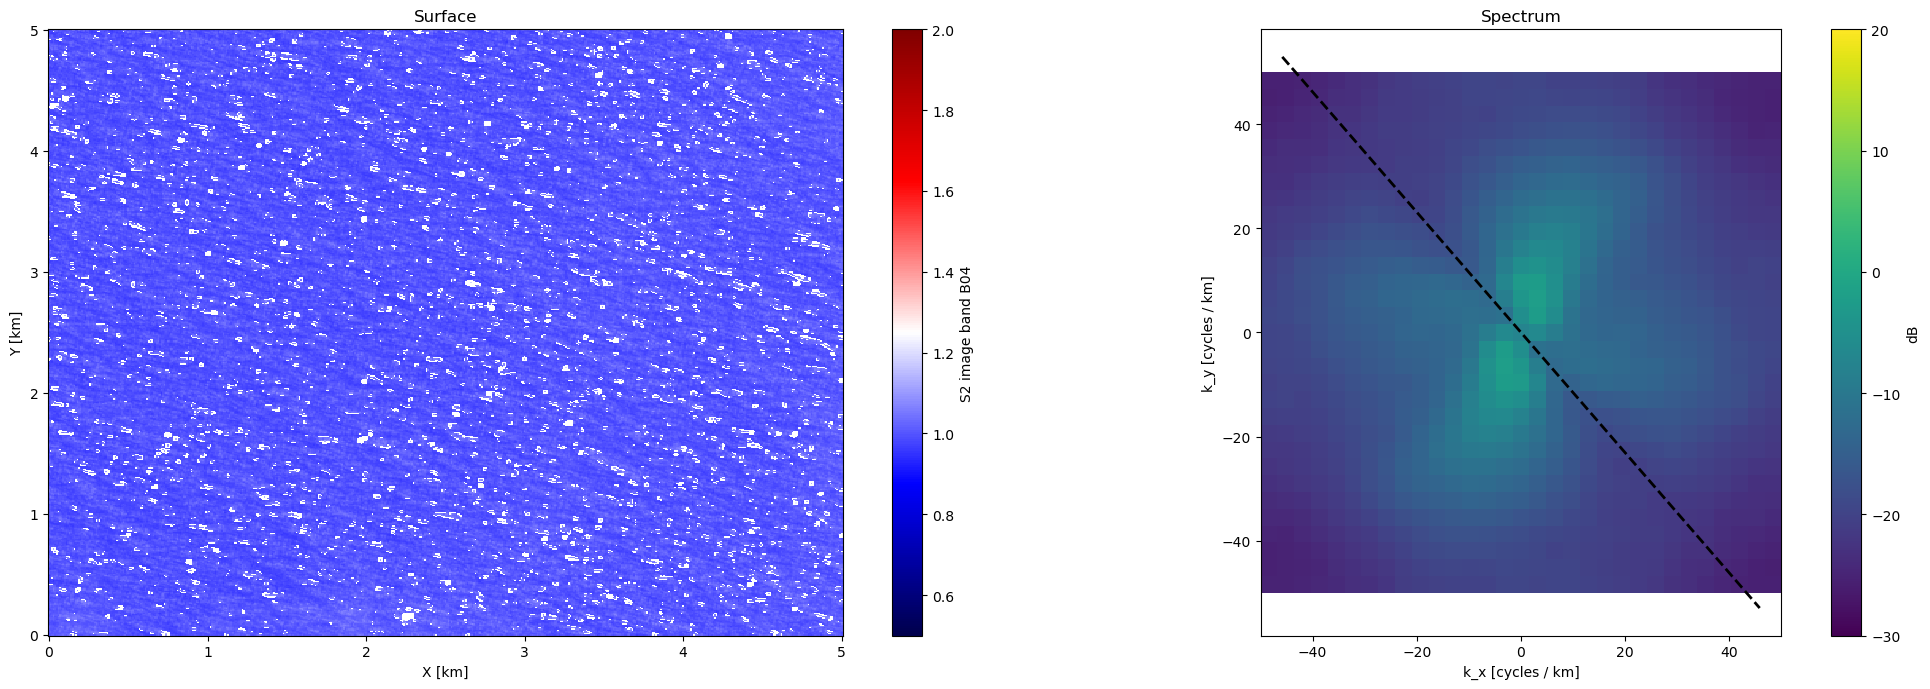

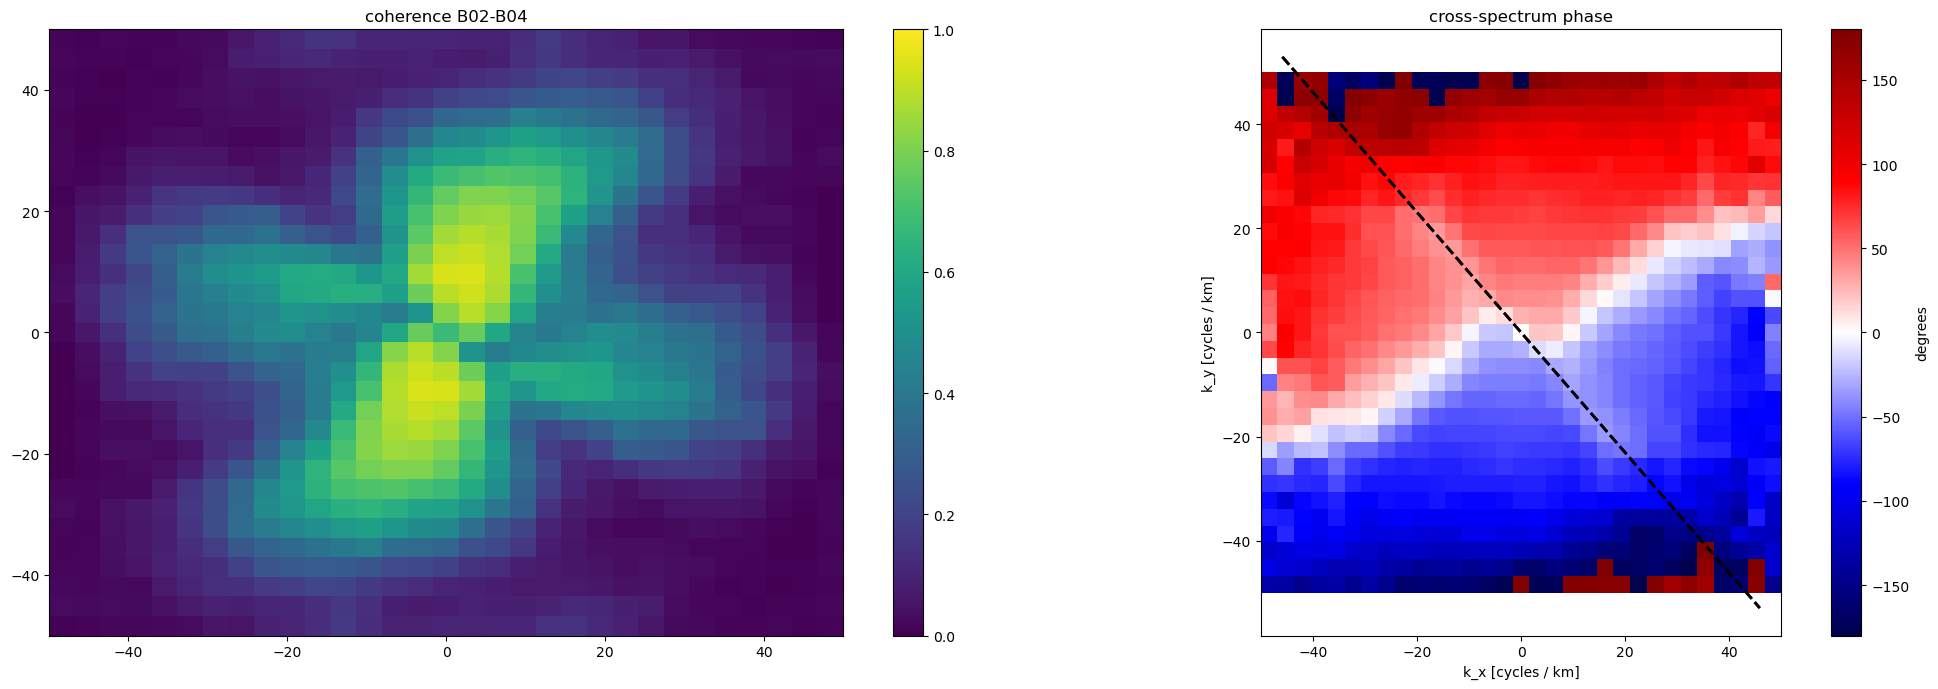

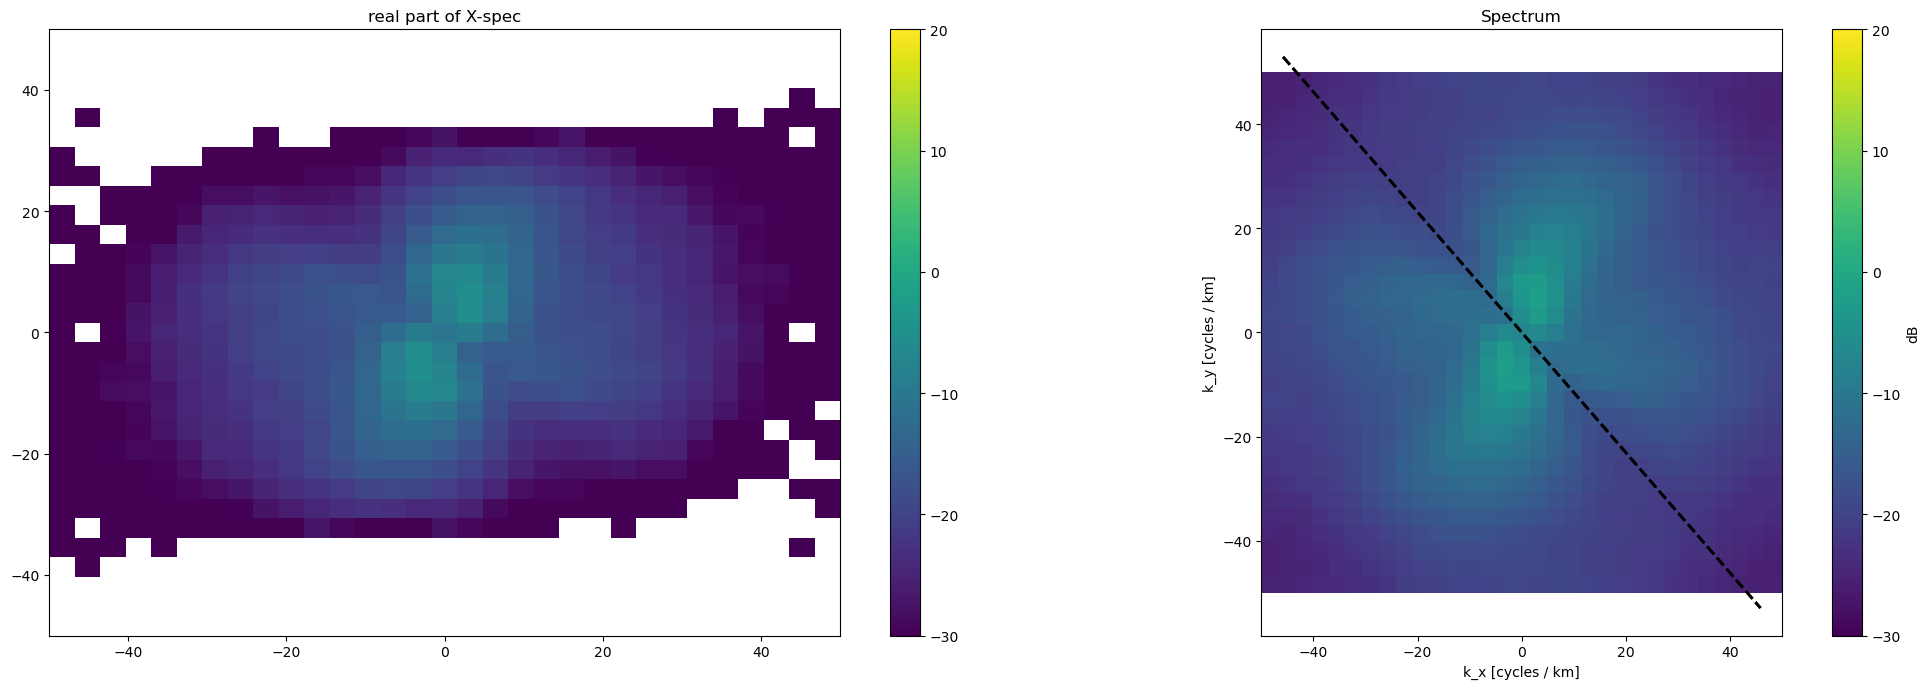

In [14]:

ntile=16
# (Eta,Etb,ang,angstd,coh,crosr,phases,kx2,ky2,dkx,dky)=FFT2D_two_arrays(img1,img2,10,10,ntile,isplot=0)
(Eta,Etb,ang,angstd,coh,crosr,phases,kx2,ky2,dkx,dky)=FFT2D_two_arrays_nonan(filtered_image1,filtered_image2,10,10,ntile,isplot=0)

print(np.shape(Eta))
print(np.shape(kx2))
print(np.shape(ky2))


phiblind1=phitrig[0]+90.  # blind azimuth for first band
phiblind2=phitrig[1]+90.  # blind azimuth for 3rd band
phiblind3=phitrig[2]+90.  # blind azimuth for 3rd band
kN=50
xkblind=[-1.4*kN*np.sin(np.radians(phiblind2)) , 1.4*kN*np.sin(np.radians(phiblind2))]
ykblind=[-1.4*kN*np.cos(np.radians(phiblind2)) , 1.4*kN*np.cos(np.radians(phiblind2))]


X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
Y = np.arange(0,ny*dy,dy)

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

# warning: we use an array img1 that is written with X in the first (number 0) dimension and Y in the second
#          but pcolormesh uses the opposite order: hence the use of transpose 

im=axs[0].pcolormesh(X/1000,Y/1000,np.transpose(filtered_image1),cmap='seismic',norm = mcolors.Normalize(vmin=0.5, vmax=2))
_=plt.colorbar(im,ax=axs[0],label='S2 image band B04')
_=axs[0].set_xlabel('X [km]')
_=axs[0].set_ylabel('Y [km]')
_=axs[0].set_title('Surface')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Eta)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('Spectrum')
_=plt.tight_layout()

print('variance 1:',np.var(img1.flatten()), 'sum of spectrum:',np.sum(Eta.flatten())*dkx*dky )
print('variance 2:',np.var(img2.flatten()), 'sum of spectrum:',np.sum(Etb.flatten())*dkx*dky )


fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,coh,norm = mcolors.Normalize(vmin=0, vmax=1))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('coherence B02-B04')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,np.degrees(ang),cmap='seismic',norm = mcolors.Normalize(vmin=-180, vmax=180))
_=plt.colorbar(im,ax=axs[1],label='degrees')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('cross-spectrum phase')
_=plt.tight_layout()

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10((crosr)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('real part of X-spec')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Eta)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('Spectrum')
_=plt.tight_layout()


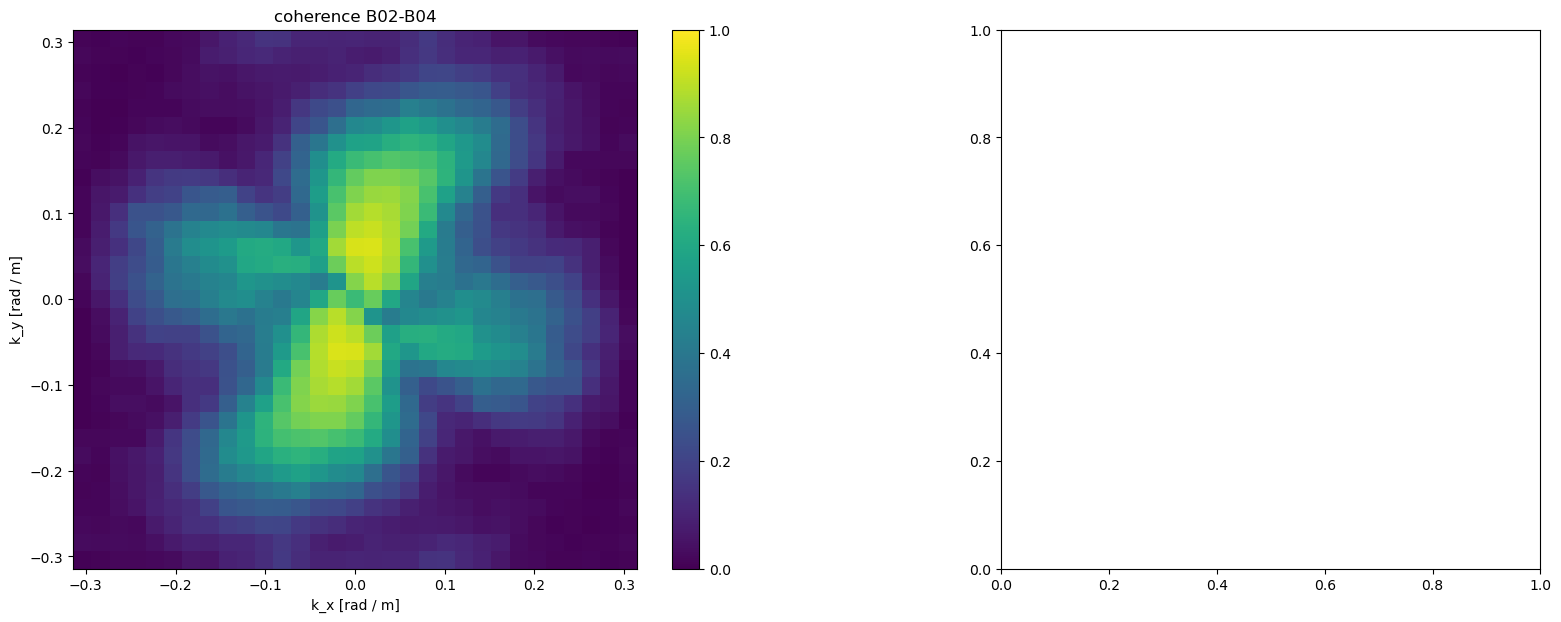

In [15]:
fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*2*np.pi,ky2*2*np.pi,coh,norm = mcolors.Normalize(vmin=0, vmax=1))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=axs[0].set_xlabel('k_x [rad / m]')
_=axs[0].set_ylabel('k_y [rad / m]')
_=axs[0].set_title('coherence B02-B04')


In [25]:
#%run spectral_analysis_functions.py